# Part 1: Data
Create synthetic multi-variate Gaussian data using parameters I chose

In [211]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

In [265]:
m = 2
n = 1000
d = 1
w = [2, 4]
μ = [-3, 9]
σ = [1, 1]


In [266]:
data = sum((torch.randn(n, d) * σ[i] + μ[i]) * w[i] for i in range(m))

In [267]:
print(data[:10])
print(data.shape)

tensor([[26.7407],
        [24.0598],
        [33.3444],
        [36.1487],
        [30.0225],
        [27.3055],
        [34.0829],
        [25.1131],
        [23.4654],
        [24.1203]])
torch.Size([1000, 1])


In [268]:
train_data = data[:n//2]
test_data = data[n//2:]
train_dataloader = DataLoader(train_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)

# Part 2.2: Score Matching
Match scores with a NN with loss
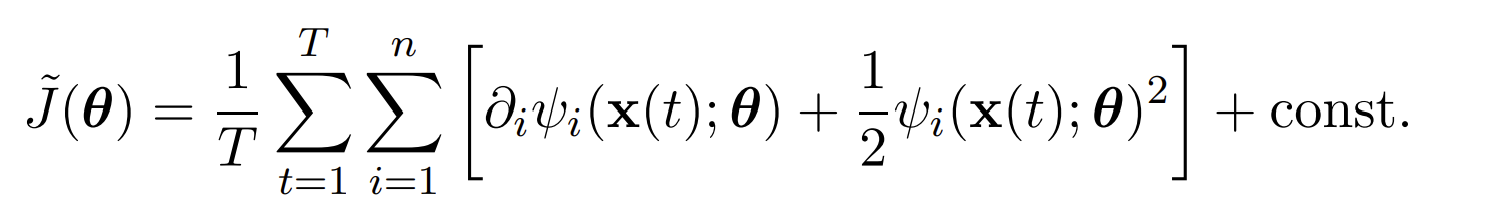 
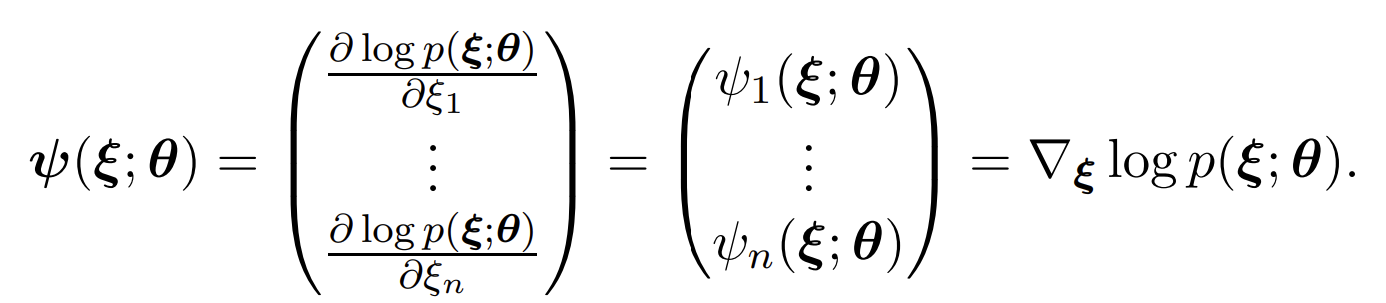

## Part 2.21: Model

In [270]:
class ScoreMatcher(nn.Module):
    def __init__(self):
        super(ScoreMatcher, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(d, 10),
            nn.ReLU(),
            nn.Linear(10, 10),
            nn.ReLU(),
            nn.Linear(10, 1)
        )

    def forward(self, x):
        return self.net(x)

def score_matching_loss(model, X):
    loss = 0
    for x in X:
        x.requires_grad_(True)
        φ = torch.autograd.functional.jacobian(lambda x: torch.log(model(x)), x, create_graph=True)[0].clone()
        # print(φ)
        J = torch.autograd.functional.hessian(lambda x: torch.log(model(x)), x, create_graph=True).clone()
        loss += torch.trace(J) + .5 * torch.dot(φ, φ)
    # print(loss/X.shape[0])
    return loss/X.shape[0]
    
# def score_matching_loss(model, X):
#     J = torch.autograd.functional.jacobian(model, X)
#     J = 
#     return sum()
#     X.requires_grad_(True)
#     Y = model(X)
#     Y.requires_grad_(True)
#     φ = torch.autograd.grad(Y, X, create_graph=True, grad_outputs=torch.ones_like(Y))[0].clone()
#     print(φ.shape)
#     φ.requires_grad_(True)
#     φ2 = torch.autograd.grad(φ, X, retain_graph=True, grad_outputs=torch.ones_like(Y))[0].clone()
#     print(φ2.shape)
#     φ = φ.squeeze(1)
#     loss = φ2 + .5 * torch.dot(φ, φ)
#     loss = loss.squeeze(1)
#     print("loss", loss.shape, loss)
#     return sum(loss)/X.shape[0]


# Initialize model, optimizer, etc.
model = ScoreMatcher()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 5

for epoch in range(num_epochs):
    for X in train_dataloader:
        output = model(X)
        loss = score_matching_loss(model, X)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


In [269]:
data.shape

torch.Size([1000, 1])

## Part 2.22: Sample

In [209]:
step_size = 0.1     
num_steps = 100
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [276]:
def sample_langevin_dynamics(model, n):
    X = torch.randn(n, 1)
    for _ in range(num_steps):
        X.requires_grad_(True)
        score = torch.log(model(X))
        grad = torch.autograd.grad(score, X)[0]
        X = X.detach() + step_size * grad + torch.randn(n) * step_size
    return X

In [277]:
sm_data = sample_langevin_dynamics(model, n).detach()
plt.hist(sm_data.squeeze(1), bins=12)

RuntimeError: mat1 and mat2 shapes cannot be multiplied (1x1000 and 1x10)

torch.Size([1000, 1])


(array([  5.,  14.,  42., 114., 169., 214., 189., 135.,  79.,  31.,   7.,
          1.]),
 array([15.68959236, 18.15973282, 20.62987137, 23.10001183, 25.57015228,
        28.04029274, 30.5104332 , 32.98057175, 35.45071411, 37.92085266,
        40.39099121, 42.86113358, 45.33127213]),
 <BarContainer object of 12 artists>)

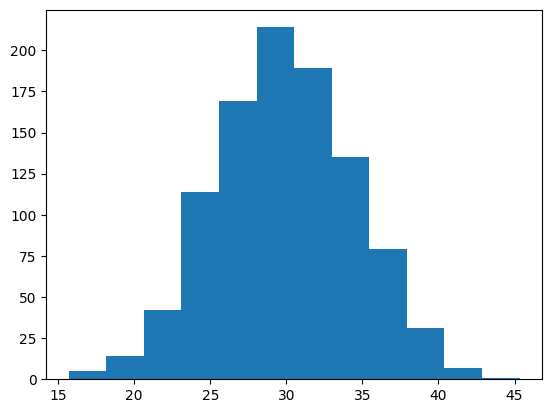

In [208]:
plt.hist(data.squeeze(1), bins=12)